<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/DifferentiableRenderingSDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
from jax import jit, vmap, grad
import jax

In [2]:
import matplotlib.pyplot as plt

In [3]:
def render_pixel(uvt):
  uv = uvt[0:2]
  time = uvt[2]

  def vec3(x, y, z):
    return jnp.array([x, y, z])

  def mag(v):
    return jnp.sqrt(v.dot(v))

  def normalize(v):
    return v / mag(v)

  def sdf_sphere(v, r):
    return mag(v) - r

  def scene(p):
    return sdf_sphere(p, 0.6)

  sdf_normal = grad(scene)
  ray_dir = normalize(vec3(*uv, 1.0))
  ray_pos = vec3(0.0, 0.0, -2.0)
  eps = 0.001
  max_dist = 100
  bg_color = vec3(0.0, 0.0, 0.0)

  def raymarch_step(d):
    d_s = scene(ray_pos + ray_dir * d[0] * 0.95)
    return d[0] + d_s, d_s

  run_condition = lambda d : jnp.where((d[1] > eps) & (d[1] < max_dist), True, False)

  dist_i = scene(ray_pos)
  dist_o, dist_s = jax.lax.while_loop(run_condition, raymarch_step, (dist_i, dist_i))

  intersect_mask = (dist_s < eps).astype(jnp.float32)

  def color(p):
    light_dir = normalize(vec3(0.2,-0.4,-1.0))
    normal = sdf_normal(p)
    light = jnp.maximum(normal.dot(light_dir), 0.0)
    return jnp.array([0.8, 0.1, 0.15]) * light

  intersect_pos = ray_pos + ray_dir * dist_o
  obj_color = color(intersect_pos)

  return intersect_mask * obj_color + (1.0 - intersect_mask) * bg_color


In [4]:
img_res = 512
ax_coords = jnp.arange(img_res)/img_res-0.5
img_coords = jnp.meshgrid(ax_coords, ax_coords)
img_coords = jnp.stack([*img_coords, jnp.full((img_res, img_res), 1.0)], axis=2)

In [5]:
# x = jnp.array([-0.4, -0.4, -2.0])
# x.dot(x)
render_pixel(jnp.array([0.0, 0.0, 1.0]))

DeviceArray([0.73029673, 0.09128709, 0.13693064], dtype=float32)

In [6]:
render_pixels = jit(vmap(vmap(render_pixel)))

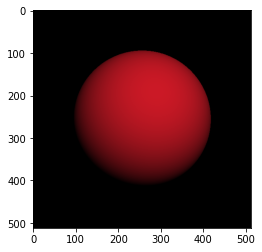

In [11]:
test_img = render_pixels(img_coords)
plt.imshow(test_img)

In [8]:
img_coords[0][0]

DeviceArray([-0.5, -0.5,  1. ], dtype=float32)

In [9]:
test_img.min()

DeviceArray(0., dtype=float32)

In [10]:
img_coords.shape

(512, 512, 3)